# Network robustness (percolation) analysis

 ### Set up

In [43]:
# Import dependencies for the complete notebook

import os
import config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
from networkx import edge_boundary
from lib.networks import get_participants, get_components, get_or_create_interaction_network
from lib.percolation import sampleLinkPercolationWithPercentages, sampleLinkPercolationWithPoints
from config import LEVELS, NETWORKS_PATH, DATA_REACTOME_PATH, INTERACTOMES_PATH
from scipy.interpolate import make_interp_spline


%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Set the working directory to the root("/") of the repository
config.set_root_wd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial working directory: C:\Users\luisp\OneDrive\Documents\phd\ProteoformNetworks\src\Python
New working directory: c:\Users\luisp\OneDrive\Documents\phd\ProteoformNetworks


 ### Create full interaction Networks with small molecules for Genes, Proteins and Proteoforms

In [44]:
# Create interactome networks and store them in the /networks/interactomes/ directory

if not Path(INTERACTOMES_PATH).exists():
    os.mkdir(INTERACTOMES_PATH)

participant_records = {l: get_participants(l, INTERACTOMES_PATH) for l in [*LEVELS, config.sm]}
components_records = {l: get_components(l, INTERACTOMES_PATH) for l in [*LEVELS, config.sm]}

interactomes = {l: get_or_create_interaction_network(l, config.no_sm, participant_records, components_records, INTERACTOMES_PATH, label="interactome", v=True) for l in LEVELS}

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for interactome at genes level, method no_sm...
Reading interaction network for interactome at proteins level, method no_sm...
Reading interaction network for interactome at proteoforms level, method no_sm...


# Approximate link percolation curve for current interactomes

We estimate 3 percolation curves, one for each granularity level: genes, proteins and proteoforms

1. Sample completeness vs lcc size
1. Plot the samples

In [45]:
num_completeness_points = 20
num_replicates = 20
step = 0.1

if not Path("reports/").exists():
    os.mkdir("reports/")

# P = getCompletenessValues(num_completeness_points)
samples = {}
file_name = 'reports/samples_link_percolation_'
for level in LEVELS:
    if Path(file_name + level + '.csv').exists():
        print(f"Reading percolation samples for {level}")
        samples[level] = pd.read_csv(file_name + level + '.csv')
    else:
        print(f'Sampling link percolation for {level}')
        samples[level] = sampleLinkPercolationWithPercentages(interactomes[level], num_replicates, step)
        print(f'Creating csv files.')
        samples[level].to_csv(file_name + level + '.csv')
samples

Reading percolation samples for genes
Reading percolation samples for proteins
Reading percolation samples for proteoforms


{'genes':       Unnamed: 0  index  Completeness  Relative Size  Replicate
 0              0      0          0.90           0.99          0
 1              1      1          0.81           0.99          0
 2              2      2          0.73           0.98          0
 3              3      3          0.66           0.97          0
 4              4      4          0.59           0.96          0
 ...          ...    ...           ...            ...        ...
 2115        2115   2115          0.00           0.00         19
 2116        2116   2116          0.00           0.00         19
 2117        2117   2117          0.00           0.00         19
 2118        2118   2118          0.00           0.00         19
 2119        2119   2119          0.00           0.00         19
 
 [2120 rows x 5 columns],
 'proteins':       Unnamed: 0  index  Completeness  Relative Size  Replicate
 0              0      0          0.90           0.99          0
 1              1      1          0.81   

### Plot link percolation curves at 3 granularity levels

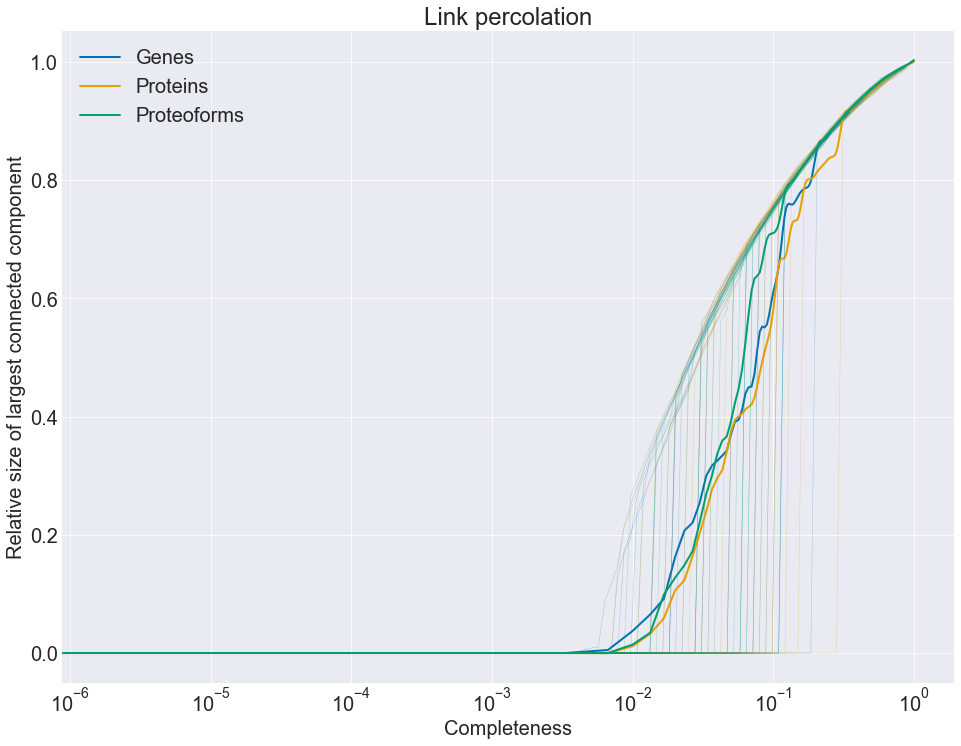

<Figure size 432x288 with 0 Axes>

In [46]:
plt.rc('font', size=20)
plt.figure(figsize=(16, 12))
plt.style.use('seaborn-darkgrid')


for level in LEVELS:
    for label, sub_df in samples[level].groupby('Replicate'):
        plt.plot(sub_df['Completeness'], sub_df['Relative Size'], marker='', linewidth=0.5, alpha=0.3, color=config.LEVELS_COLOR[level])

    df_mean = samples[level].groupby('Completeness').mean()
    df_mean = df_mean.reset_index()
    df_mean = df_mean.drop(columns=['Replicate', 'index'])

    x = df_mean['Completeness']
    y = df_mean['Relative Size']
    x_new = np.linspace(0, 1, 300)
    spl = make_interp_spline(x, y)
    y_new = spl(x_new)

    plt.plot(x_new, y_new, marker='', linewidth=2, alpha=1, color=config.LEVELS_COLOR[level], label=level.title())

plt.legend()
plt.xscale('log')
plt.title("Link percolation")
plt.xlabel("Completeness")
plt.ylabel("Relative size of largest connected component")
plt.show()
plt.savefig('figures/percolation_curves.png')

In [47]:
P = [0.5]
num_replicates = 20

# P = getCompletenessValues(num_completeness_points)
values = {}
file_name = 'reports/samples_link_percolation_0_5_'
for level in LEVELS:
    if Path(file_name + level + '.csv').exists():
        print(f"Reading percolation samples for {level}")
        values[level] = pd.read_csv(file_name + level + '.csv')
    else:
        print(f'Sampling link percolation for {level}')
        values[level] = sampleLinkPercolationWithPoints(interactomes[level], num_replicates, P)
        print(f'Creating csv files.')
        values[level].to_csv(file_name + level + '.csv')
values

Reading percolation samples for genes
Reading percolation samples for proteins
Reading percolation samples for proteoforms


{'genes':     Unnamed: 0  index  Completeness  Relative Size  Replicate
 0            0      0          0.50           0.95          0
 1            1      1          0.50           0.95          1
 2            2      2          0.50           0.95          2
 3            3      3          0.50           0.95          3
 4            4      4          0.50           0.96          4
 5            5      5          0.50           0.95          5
 6            6      6          0.50           0.95          6
 7            7      7          0.50           0.95          7
 8            8      8          0.50           0.95          8
 9            9      9          0.50           0.95          9
 10          10     10          0.50           0.95         10
 11          11     11          0.50           0.95         11
 12          12     12          0.50           0.96         12
 13          13     13          0.50           0.95         13
 14          14     14          0.50          

In [48]:
interactomes_with_sm = {l: get_or_create_interaction_network(l, config.with_sm, participant_records, components_records, INTERACTOMES_PATH, label="interactome_with_sm_", v=True) for l in LEVELS}

Reading interaction network for interactome_with_sm_ at genes level, method with_sm...
Reading interaction network for interactome_with_sm_ at proteins level, method with_sm...
Reading interaction network for interactome_with_sm_ at proteoforms level, method with_sm...


### Sample completeness vs lcc size

In [49]:
num_replicates = 20
step = 0.1

# P = getCompletenessValues(num_completeness_points)
samples = {}
file_name = 'reports/samples_link_percolation_sm_'
for level in LEVELS:
    if Path(file_name + level + '.csv').exists():
        print(f"Reading percolation samples for {level}")
        samples[level] = pd.read_csv(file_name + level + '.csv')
    else:
        print(f'Sampling link percolation for {level}')
        samples[level] = sampleLinkPercolationWithPercentages(interactomes_with_sm[level], num_replicates, step)
        print(f'Creating csv files.')
        samples[level].to_csv(file_name + level + '.csv')
samples

Reading percolation samples for genes
Reading percolation samples for proteins
Reading percolation samples for proteoforms


{'genes':       Unnamed: 0  index  Completeness  Relative Size  Replicate
 0              0      0          0.90           1.00          0
 1              1      1          0.81           0.99          0
 2              2      2          0.73           0.98          0
 3              3      3          0.66           0.97          0
 4              4      4          0.59           0.96          0
 ...          ...    ...           ...            ...        ...
 2155        2155   2155          0.00           0.00         19
 2156        2156   2156          0.00           0.00         19
 2157        2157   2157          0.00           0.00         19
 2158        2158   2158          0.00           0.00         19
 2159        2159   2159          0.00           0.00         19
 
 [2160 rows x 5 columns],
 'proteins':       Unnamed: 0  index  Completeness  Relative Size  Replicate
 0              0      0          0.90           0.99          0
 1              1      1          0.81   

### Plot link percolation curves at 3 granularity levels

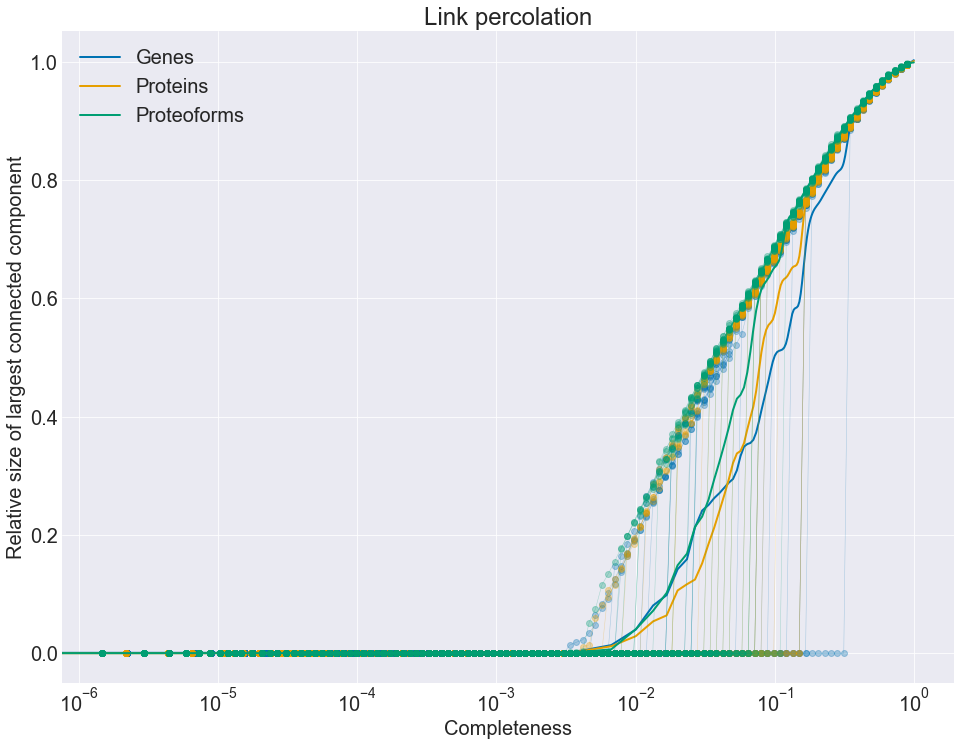

In [50]:
plt.rc('font', size=20)
plt.figure(figsize=(16, 12))
plt.style.use('seaborn-darkgrid')


for level in LEVELS:
    for label, sub_df in samples[level].groupby('Replicate'):
        plt.plot(sub_df['Completeness'], sub_df['Relative Size'], marker='o', linewidth=0.5, alpha=0.3, color=config.LEVELS_COLOR[level])

    df_mean = samples[level].groupby('Completeness').mean()
    df_mean = df_mean.reset_index()
    df_mean = df_mean.drop(columns=['Replicate', 'index'])

    x = df_mean['Completeness']
    y = df_mean['Relative Size']
    x_new = np.linspace(0, 1, 300)
    spl = make_interp_spline(x, y)
    y_new = spl(x_new)

    plt.plot(x_new, y_new, marker='', linewidth=2, alpha=1, color=config.LEVELS_COLOR[level], label=level.title())

plt.legend()
plt.xscale('log')
plt.title("Link percolation")
plt.xlabel("Completeness")
plt.ylabel("Relative size of largest connected component")
plt.show()


### Calculate subgraphs separating mm, um, uu

In [51]:
nodes_mm = [node for node in interactomes['proteoforms'].nodes if ':' in str(node)]
nodes_uu = [node for node in interactomes['proteoforms'].nodes if not ':' in str(node)]
edges_um = edge_boundary(interactomes['proteoforms'], nodes_mm, nodes_uu)

print(f"Nodes with modified proteoforms:")
print(nodes_mm[1:5])

print(f"Nodes with not modified proteoforms:")
print(nodes_uu[1:5])

subgraphs = dict()
subgraphs['mm'] = interactomes['proteoforms'].subgraph(nodes_mm).copy(as_view=False)
subgraphs['uu'] = interactomes['proteoforms'].subgraph(nodes_uu).copy(as_view=False)
subgraphs['um'] = nx.Graph()
subgraphs['um'].add_edges_from(edges_um)

print(f"Original interactome edges: {interactomes['proteoforms'].number_of_edges()}, original interactome nodes: {interactomes['proteoforms'].number_of_nodes()}")
print(f"mm: edges: {subgraphs['mm'].number_of_edges()}, vertices: {subgraphs['mm'].number_of_nodes()}" )
print(f"uu: edges: {subgraphs['uu'].number_of_edges()}, vertices: {subgraphs['uu'].number_of_nodes()}" )

Nodes with modified proteoforms:
['P23458;00048:1034', 'P29597;00048:1054', 'P40189-1;00048:759,00048:767,00048:814,00048:905,00048:915', 'P40763;00048:705']
Nodes with not modified proteoforms:
['P05231;', 'O60674;', 'P23458;', 'P29597;']
Original interactome edges: 590204, original interactome nodes: 14340
mm: edges: 141602, vertices: 3266
uu: edges: 352863, vertices: 11074


### Sample completeness vs lcc size for mm, uu, mu

In [52]:
num_replicates = 3
step = 0.1

samples = {}
file_name = 'reports/samples_link_percolation_by_mm'
subnames = ['mm', 'uu', 'um']
for name in subnames:
    if Path(file_name + level + '.csv').exists():
        print(f"Reading percolation samples for {name}")
        samples[name] = pd.read_csv(file_name + name + '.csv')
    else:
        print(f'Sampling link percolation for {name}')
        samples[name] = sampleLinkPercolationWithPercentages(subgraphs[name], num_replicates, step)
        print(f'Creating csv files.')
        samples[name].to_csv(file_name + name + '.csv')
samples

Sampling link percolation for mm
Done replicate 0
Done replicate 1
Done replicate 2
Creating csv files.
Sampling link percolation for uu
Done replicate 0
Done replicate 1
Done replicate 2
Creating csv files.
Sampling link percolation for um
Done replicate 0
Done replicate 1
Done replicate 2
Creating csv files.


{'mm':      index  Completeness  Relative Size  Replicate
 0        0          0.90           0.99          0
 1        1          0.81           0.98          0
 2        2          0.73           0.96          0
 3        3          0.66           0.94          0
 4        4          0.59           0.92          0
 ..     ...           ...            ...        ...
 286    286          0.00           0.00          2
 287    287          0.00           0.00          2
 288    288          0.00           0.00          2
 289    289          0.00           0.00          2
 290    290          0.00           0.00          2
 
 [291 rows x 4 columns],
 'uu':      index  Completeness  Relative Size  Replicate
 0        0          0.90           1.00          0
 1        1          0.81           0.99          0
 2        2          0.73           0.99          0
 3        3          0.66           0.98          0
 4        4          0.59           0.97          0
 ..     ...           ...

### Plot link percolation curves for mm, uu and um

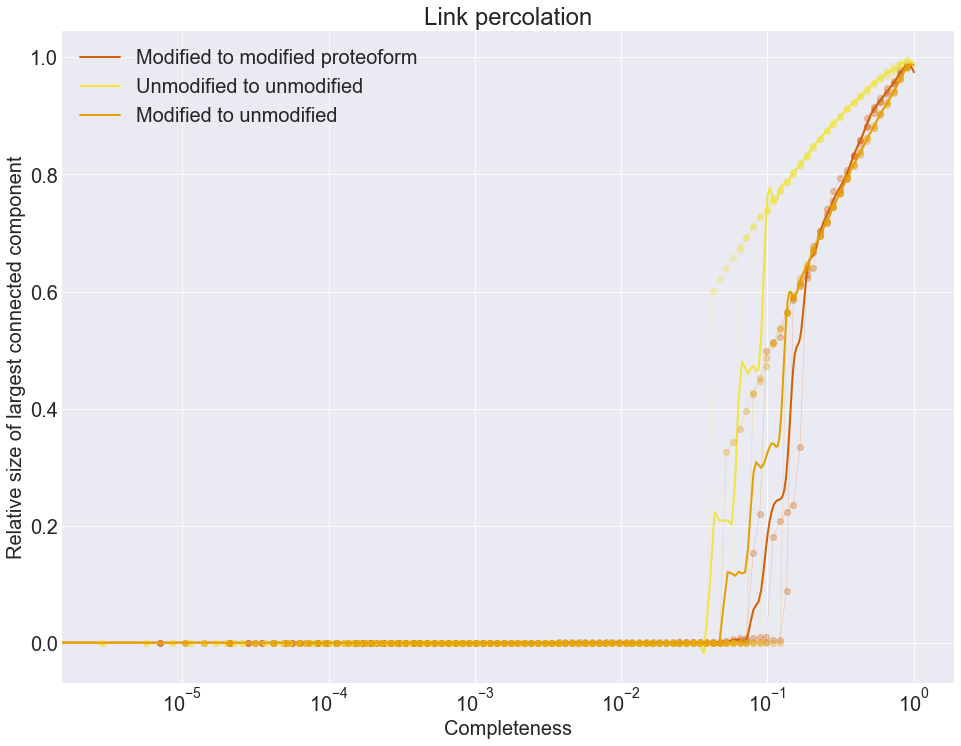

In [53]:
plt.rc('font', size=20)
plt.figure(figsize=(16, 12))
plt.style.use('seaborn-darkgrid')

labels = {'mm': 'Modified to modified proteoform',
          'uu': 'Unmodified to unmodified',
          'um': 'Modified to unmodified'}

for name in subnames:
    for label, sub_df in samples[name].groupby('Replicate'):
        plt.plot(sub_df['Completeness'], sub_df['Relative Size'], marker='o',
                 linewidth=0.5, alpha=0.3, color=config.PROTEOFORMS_SUBGRAPHS_COLOR[name])

    df_mean = samples[name].groupby('Completeness').mean()
    df_mean = df_mean.reset_index()
    df_mean = df_mean.drop(columns=['Replicate', 'index'])

    x = df_mean['Completeness']
    y = df_mean['Relative Size']
    x_new = np.linspace(0, 1, 300)
    spl = make_interp_spline(x, y)
    y_new = spl(x_new)

    plt.plot(x_new, y_new, marker='',
             linewidth=2, alpha=1, color=config.PROTEOFORMS_SUBGRAPHS_COLOR[name], label=labels[name])

plt.legend()
plt.xscale('log')
plt.title("Link percolation")
plt.xlabel("Completeness")
plt.ylabel("Relative size of largest connected component")
plt.show()